# Hockey Technical Report

## Team members
- Cole Stainsby
- Drew Bogdan
- Zach Ambroseo

## Introduction
 The dataset we used for this project was an NHL league standings dataset, found [here](http://inalitic.com/datasets/nhl_leaguestandings_data.html), that contains the standings from every season since 1940. We added an extra column to correspond to positions within the playoffs. The dataset had a wealth of information and for our project we wanted to determine how well a team placed this within playoffs using a kNN classifier, a decision tree and a Random Forest. Out of these classifiers, the decision tree performed the best with our dataset and code. 


In [5]:
import importlib
import matplotlib.pyplot as plt
import plot_utils as plt_utils
import numpy as np

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

In [6]:
league_standing_pytable = MyPyTable()
league_standing_pytable.load_from_file("lib/nhl_leaguestandings.csv")

## Data Analysis

In [15]:
class_col = league_standing_pytable.get_column("PLAYOFFS")
print("Total Instances: ", len(class_col))

group_names, group_instances = myutils.group_by(league_standing_pytable.data, league_standing_pytable.column_names, "PLAYOFFS")

print("Avalible Classifications and Total Number Of Class Encountered")
for i in range(len(group_names)):
    print("  " + group_names[i] + " : " + str(len(group_instances[i])))

year_col = league_standing_pytable.get_column("SEASON")
print("Most recent year in data: ", int(max(year_col)))
print("Earliest year accounted for in data: ", int(min(year_col)))

print("Number of teams in recent year: ", year_col.count(max(year_col)))
print("Number of teams in earliest year: ", year_col.count(min(year_col)))

Total Instances:  1350
Avalible Classifications and Total Number Of Class Encountered
  N : 508
  Y : 842
Most recent year in data:  2018
Earliest year accounted for in data:  1940
Number of teams in recent year:  31
Number of teams in earliest year:  7


### Attributes

Attribute(type):description

- Season(int): The current seasonal year that the results of the instance took place in.
- Conference(str): The conference that the instance took place at.
- Division(str): The division that the instance belongs to.
- Team(str): The name of the team the instance is recorded on.
- TM(str): The abbreviated name of the team
- Playoffs(bool): An attribute that reveals if the team of the instance was at playoffs this season, uses Y for T and N for F.
- GP(int): Games played by that team in a single season
- W(int): Games won by a team in the given season
- L(int):Games lost by a team in the given season
- T(int): Games tied by a team in a given season
- OL(int): Games lost in shootout or overtime by a team in a given season
- PTS(int): Points scored by a team in a given season based off the win loss record.
- PTS%(float): Total points achieve by a team in a given season divided by total possible points
- GF(int): Number of goals scored in favor of a team during a given season
- Ga(int): Number of goals scored against a team during a given season
- SRS(int): Goals scored by a player during a power play
- SOS(int): Goals scored by player while a team is shorthanded, down a player due to penalty.
- RPT%(int): Game winning goals scored by a player in a given season
- ROW(int): Assists occurring while team is even strength
- FINISH(int): An integer that our group created from 0-5 that corresponds to a team’s final position. 0 - missed, 1 - lost round 1, 2 -  lost divisional finals, 3 - lost conference finals, 4 - lost the cup finals, 5 - won finals

Row Label: SEASON_TM


### Summary Statistics

In [11]:
import importlib
import matplotlib.pyplot as plt
import plot_utils as plt_utils
import numpy as np

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 
league_standing_pytable = MyPyTable()
sum_table = MyPyTable()
league_standing_pytable.load_from_file("lib/nhl_leaguestandings.csv")

importlib.reload(mysklearn)
column_names=league_standing_pytable.column_names
table=league_standing_pytable.data

sum_table=league_standing_pytable.compute_summary_statistics(league_standing_pytable,column_names)
sum_table.pretty_print()


TypeError: compute_summary_statistics() takes 2 positional arguments but 3 were given

### EDA 1 - Wins vs Losses with a line for play off cutoffs

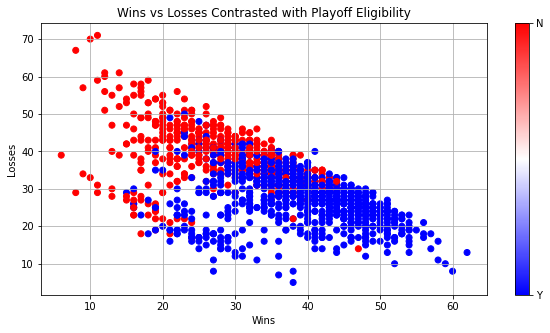

In [8]:
importlib.reload(mysklearn)

dataset_titles = league_standing_pytable.column_names
dataset = league_standing_pytable.data
x_col_name = "W"
y_col_name = "L"
groupby_col = "PLAYOFFS"

wins_col = league_standing_pytable.get_column(x_col_name)
losses_col = league_standing_pytable.get_column(y_col_name)
class_col = league_standing_pytable.get_column(groupby_col)

unique_class_vals, parallel_numbered_vals = myutils.unique_vals(class_col)

x_index = dataset_titles.index(x_col_name)
y_index = dataset_titles.index(y_col_name)

cleaned_x, cleaned_y = myutils.find_all_non_NA_matches(wins_col, losses_col)
m, b = myutils.compute_slope_intercept(cleaned_x, cleaned_y)

corre_coeff = myutils.calculate_correlation_coefficient(cleaned_x, cleaned_y)
covarience = myutils.calculate_covarience(cleaned_x, cleaned_y)

plt.figure(figsize=(10,5))
plt.title("Wins" + " vs " + "Losses Contrasted with Playoff Eligibility")
plt.ylabel("Losses")
plt.xlabel("Wins")
plt.scatter(cleaned_x, cleaned_y, c = parallel_numbered_vals, marker="o", cmap="bwr")
#plt.plot([min(cleaned_x), max(cleaned_x)], [m * min(cleaned_x) + b, m * max(cleaned_x) + b], c="g")
cbar = plt.colorbar()
cbar.set_ticks([i for i in range(len(unique_class_vals))])
cbar.set_ticklabels(unique_class_vals)
plt.grid(True)
plt.show()


As the title of this plot suggests it focuses on the comparison between wins and losses and playoffs eligibility. In our EDA we were searching for correlations and we started with one of the simpler ones to check. However, having a high amount of wins does not always equate to a spot in the playoffs as proven by some points on the plot, but the chances do increase dramatically  with wins.


### EDA 2 -Points scored by a given team in the seasons
Two charts which cover the distribution of points of a given group
1. Teams who were in the playoffs
1. Teams who weren't in the playoffs

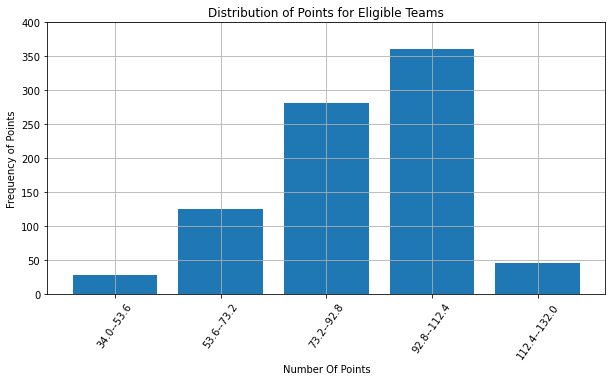

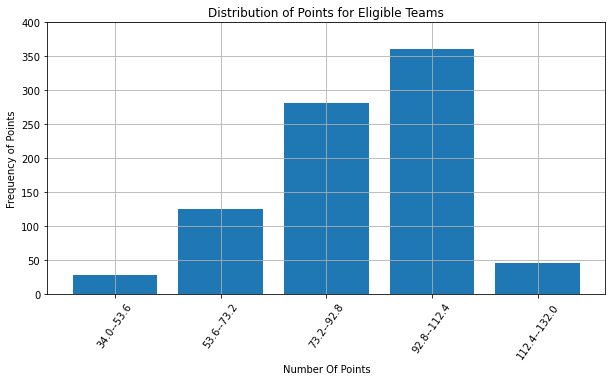

In [9]:
importlib.reload(mysklearn)

dataset_titles = league_standing_pytable.column_names
dataset = league_standing_pytable.data
x_col_name = "PTS"
groupby_col = "PLAYOFFS"

group_names, group_subtables = myutils.group_by(dataset, dataset_titles, groupby_col)
no_pytable = MyPyTable(dataset_titles, group_subtables[0])
yes_pytable = MyPyTable(dataset_titles, group_subtables[1])

yes_pts_col = yes_pytable.get_column(x_col_name)
no_pts_col = no_pytable.get_column(x_col_name)

# ------------------------------------------- 
#   for yes
# -------------------------------------------
cutoffs = myutils.compute_equal_width_cutoffs(yes_pts_col, 5)

binned_values = []
bin_labels = [i for i in range(1,6)]
bin_names = [str(cutoffs[i]) + "--" + str(cutoffs[i + 1]) for i in range(len(cutoffs) - 1)]
for i in range(len(yes_pts_col)):
    j = 0

    while yes_pts_col[i] > cutoffs[j]:
        j += 1
    binned_values.append(j)

binned_frequencies = []
for i in range(1, 6):
    binned_frequencies.append(binned_values.count(i))

plt.figure(figsize=(10,5))
x_range = np.arange(len(bin_labels))
y_range = np.arange(0, max(binned_frequencies) * 1.2, 50)
plt.bar(x_range, binned_frequencies, align="center")
plt.xticks(x_range, bin_names, rotation=55)
plt.yticks(y_range)
plt.title("Distribution of Points for Eligible Teams")
plt.ylabel("Frequency of Points")
plt.xlabel("Number Of Points")
plt.grid(True)
plt.show()


# ------------------------------------------- 
#   for no
# -------------------------------------------
cutoffs = myutils.compute_equal_width_cutoffs(yes_pts_col, 5)

binned_values = []
bin_labels = [i for i in range(1,6)]
bin_names = [str(cutoffs[i]) + "--" + str(cutoffs[i + 1]) for i in range(len(cutoffs) - 1)]
for i in range(len(yes_pts_col)):
    j = 0

    while yes_pts_col[i] > cutoffs[j]:
        j += 1
    binned_values.append(j)

binned_frequencies = []
for i in range(1, 6):
    binned_frequencies.append(binned_values.count(i))

plt.figure(figsize=(10,5))
x_range = np.arange(len(bin_labels))
y_range = np.arange(0, max(binned_frequencies) * 1.2, 50)
plt.bar(x_range, binned_frequencies, align="center")
plt.xticks(x_range, bin_names, rotation=55)
plt.yticks(y_range)
plt.title("Distribution of Points for Eligible Teams")
plt.ylabel("Frequency of Points")
plt.xlabel("Number Of Points")
plt.grid(True)
plt.show()

### EDA 3 - How many teams made Playoffs

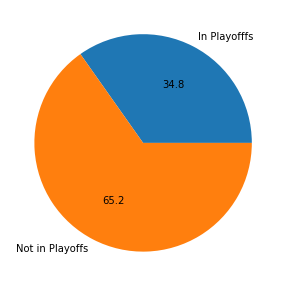

The total number of teams is 46


In [12]:
import importlib
import matplotlib.pyplot as plt
import plot_utils as plt_utils
import numpy as np

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 
league_standing_pytable = MyPyTable()
league_standing_pytable.load_from_file("lib/nhl_leaguestandings.csv")

importlib.reload(mysklearn)
column_names=league_standing_pytable.column_names
table=league_standing_pytable.data
plt.figure(figsize=(10,5))
 
year_col=league_standing_pytable.get_column("SEASON")
year_table=[]
year_index=column_names.index("SEASON")
team_index=column_names.index("TEAM")
playoff_index=column_names.index("PLAYOFFS")
 
for row in table:
   if row[year_index]==2018:
       year_table.append(row)
 
teams=league_standing_pytable.get_column("TEAM")
team_names=[]
for i in range(len(teams)):
   if teams[i] in team_names:
       continue
   else:
       team_names.append(teams[i])
 
inP=[]
for row in year_table:
   if row[team_index] in inP:
       continue
   else:
       if row[playoff_index] == "Y":
           inP.append(row[team_index])
 
noP=len(team_names)-len(inP)
success=[len(inP), noP]
label=["In Playofffs", "Not in Playoffs"]
total_teams=len(team_names)

plt.pie(success,labels=label,autopct="%1.1F")
plt.show()
print("The total number of teams is", total_teams)

This is an extraordinarily simple pie chart that illustrates if a team made it into the playoffs or not in the most recent year. It is incredibly helpful to the project since most of the EDA off of playoffs eligibility. Only a certain number of teams can make it into the playoffs and knowing the percentage gives us a general idea of our results, which was the goal of this plot’s creation.

### EDA 4 Goals Scored vs Goals Against vs Playoff Eligibility

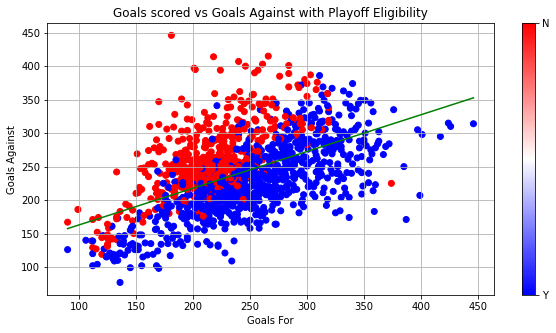

In [10]:
importlib.reload(mysklearn)

dataset_titles = league_standing_pytable.column_names
dataset = league_standing_pytable.data
x_col_name = "GF"
y_col_name = "GA"
groupby_col = "PLAYOFFS"

wins_col = league_standing_pytable.get_column(x_col_name)
losses_col = league_standing_pytable.get_column(y_col_name)
class_col = league_standing_pytable.get_column(groupby_col)

unique_class_vals, parallel_numbered_vals = myutils.unique_vals(class_col)

x_index = dataset_titles.index(x_col_name)
y_index = dataset_titles.index(y_col_name)

cleaned_x, cleaned_y = myutils.find_all_non_NA_matches(wins_col, losses_col)
m, b = myutils.compute_slope_intercept(cleaned_x, cleaned_y)

corre_coeff = myutils.calculate_correlation_coefficient(cleaned_x, cleaned_y)
covarience = myutils.calculate_covarience(cleaned_x, cleaned_y)

plt.figure(figsize=(10,5))
plt.title("Goals scored vs Goals Against with Playoff Eligibility")
plt.ylabel("Goals Against")
plt.xlabel("Goals For")
plt.scatter(cleaned_x, cleaned_y, c = parallel_numbered_vals, marker="o", cmap="bwr")
plt.plot([min(cleaned_x), max(cleaned_x)], [m * min(cleaned_x) + b, m * max(cleaned_x) + b], c="g")
cbar = plt.colorbar()
cbar.set_ticks([i for i in range(len(unique_class_vals))])
cbar.set_ticklabels(unique_class_vals)
plt.grid(True)
plt.show()

This plot checks how many a team scored or had scored on them and then checks for if they won. This plot is also interesting. Similar to the previous plot a higher amount of goals scored does not always equate to getting into playoffs. A team can score a large amount of goals, but not win a game, or can score a large amount of goals in one game and little the next game, so this is not a very useful comparison.

### EDA 5 Different teams made it to and won Finals

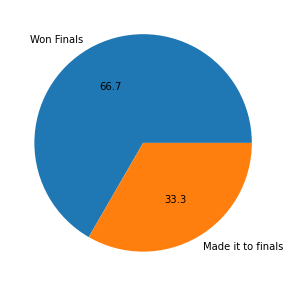

The total teams that made it to finals are 30


In [13]:
import importlib
import matplotlib.pyplot as plt
import plot_utils as plt_utils
import numpy as np

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 
league_standing_pytable = MyPyTable()
league_standing_pytable.load_from_file("lib/nhl_leaguestandings.csv")

importlib.reload(mysklearn)
column_names=league_standing_pytable.column_names
table=league_standing_pytable.data
plt.figure(figsize=(10,5))

team_index=column_names.index("TEAM")
finish_index=column_names.index("FINISH")

teams=league_standing_pytable.get_column("TEAM")
team_names=[]
for i in range(len(teams)):
   if teams[i] in team_names:
       continue
   else:
       team_names.append(teams[i])

inF=[]

for row in table:
   if row[team_index] in inF:
       continue
   else:
       if row[finish_index] >3:
           inF.append(row[team_index])

wF=[]
for row in table:
   if row[team_index] in wF:
       continue
   else:
       if row[finish_index] ==5 :
           wF.append(row[team_index])

dif= len(inF)-len(wF)
success=[len(wF), dif]
label=["Won Finals", "Made it to finals"]

plt.pie(success,labels=label,autopct="%1.1F")
plt.show()
print("The total teams that made it to finals are", len(inF))

If a team was a able to make it to the finals they are liekly to have one at some point over the years.

## Classification Results

needed

## Conclusion
The dataset we utlized was the nhl records. Our goal with this project was to create classifiers that are accurate in predicting a teams overall poistion in the playoffs. The dataset was missing a slight amount of information and an attribute for playoffs position however, this was corrected by our team. The classifiers we utilized were kNN, Decision Tree, and Random Forest. Overall our classifiers performed decently, though not as well as we hoped. One of the challenges for the classification that we had was that our original decision tree was splitting on each percentage in the table individually. While this was not necessarily an issue it resulted in our decision tree splitting an enormous amount of times on a few instances and did not fit with the rest of our project, so it was changed to groupings of percentages.

# Need a way to imporve performance